In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from torchvision.models.video import r3d_18
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


## Dataset

In [3]:
class RandomRotation3D(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        """
        Args:
            img (numpy.ndarray): Input 3D image numpy array.

        Returns:
            numpy.ndarray: Randomly rotated image.
        """
        # Randomly select the rotation angle
        angle = np.random.uniform(-self.degrees, self.degrees)

        # Perform rotation
        rotated_img = np.array([np.rot90(slice, k=int(angle / 90)) for slice in img])

        return rotated_img

train_transform = transforms.Compose([
    RandomRotation3D(degrees=5)
])


class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Select only the last 64 slices: 
        resized_image = resized_image[-64:, :, :]

        if self.transform:
            resized_image = self.transform(resized_image)
            
        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

    
        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}
        return sample



## ResNet18-2D with LSTM Model

In [4]:
class ResNetLSTM(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(ResNetLSTM, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Change the last fully connected layer
        self.resnet.fc = nn.Linear(512, 128)
        
        # Define LSTM parameters
        input_size = 128
        hidden_size = 64
        num_layers = 1
        bidirectional = True
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 64)  # Additional dense layer
        self.fc2 = nn.Linear(64, 1)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate*3)
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2 if bidirectional else hidden_size)

    def forward(self, x):
        batch_size, _, num_slices, h, w = x.size()
        
        # Pass through ResNet
        x = x.view(batch_size * num_slices, 1, h, w)
        x = self.resnet(x)
        
        # Reshape for LSTM
        x = x.view(batch_size, num_slices, -1)
            
        # Pass through LSTM
        x, _ = self.lstm(x)

        # Global average pooling across slices
        x, _ = torch.max(x, dim=1)

        # Apply Batch Norm
        x = self.batch_norm(x)

        
        # Apply dropout
        x = self.dropout1(x)
        
        # Pass through additional dense layer
        x = self.fc1(x)
        x = torch.relu(x)
        
        # Apply dropout
        x = self.dropout2(x)
        
        # Pass through final dense layer
        x = self.fc2(x)
        
        return x.squeeze()  

## ResNet18 3D Model

In [5]:
class ResNet18_3D(nn.Module):
    def __init__(self, dropout=0.1):
        super(ResNet18_3D, self).__init__()
        self.resnet18_3d = r3d_18(weights='DEFAULT')

        # Modify stem layer to accept single-channel input
        self.resnet18_3d.stem = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        
        # Change the last fully connected layer
        self.resnet18_3d.fc = nn.Linear(self.resnet18_3d.fc.in_features, 1)
        
        # Add Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Add Batch Normalization
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(128),
            nn.BatchNorm3d(256),
            nn.BatchNorm3d(512)
        ])
        
        # Adaptive average pooling
        self.adaptive_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.resnet18_3d.stem(x)
        x = self.batch_norms[0](x)
        x = self.resnet18_3d.layer1(x)
        x = self.batch_norms[1](x)
        x = self.resnet18_3d.layer2(x)
        x = self.batch_norms[2](x)
        x = self.resnet18_3d.layer3(x)
        x = self.batch_norms[3](x)
        x = self.resnet18_3d.layer4(x)
        x = self.batch_norms[4](x)
        x = self.adaptive_avg_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.resnet18_3d.fc(x)
        
        return x.squeeze()

## Load Model Weights & Test Data

In [6]:
resnet2d_LSTM = ResNetLSTM().to(device)
resnet2d_LSTM_cropped = ResNetLSTM().to(device)
resnet3d = ResNet18_3D().to(device)
resnet3d_cropped = ResNet18_3D().to(device)
resnet3d2 = ResNet18_3D().to(device)


current_directory = os.getcwd()
model_directory = os.path.join(current_directory, '..', 'models')
model_archive_directory = os.path.join(model_directory, 'MIN_LOSS_FINAL_NO_OUTPUTS')

# Load the weights for resnet2d_LSTM
resnet_2d_LSTM_weights = torch.load(os.path.join(model_directory, 'classification_model_resnet18_LSTM_binary_0_9_final.pth'))
resnet2d_LSTM.load_state_dict(resnet_2d_LSTM_weights)

# Load the weights for resnet2d_LSTM (cropped version)
resnet_2d_LSTM_cropped_weights = torch.load(os.path.join(model_directory, 'classification_model_resnet18_LSTM_cropped_binary_0_9_final.pth'))
resnet2d_LSTM_cropped.load_state_dict(resnet_2d_LSTM_cropped_weights)

# Load the weights for resnet3d
resnet_3d_weights = torch.load(os.path.join(model_directory, 'classification_model_resnet18_binary_0_9_final.pth'))
resnet3d.load_state_dict(resnet_3d_weights)

# Load the weights for resnet3d (cropped version)
resnet_3d_cropped_weights = torch.load(os.path.join(model_directory, 'classification_model_resnet18_cropped_binary_0_9_final.pth'))
resnet3d_cropped.load_state_dict(resnet_3d_cropped_weights)

# resnet_3d_weights_option2 = torch.load(os.path.join(model_archive_directory, 'classification_model_resnet18_binary_0_9_3.pth'))
# resnet3d2.load_state_dict(resnet_3d_weights_option2)

classification_models = [resnet2d_LSTM_cropped, resnet2d_LSTM, resnet3d_cropped, resnet3d]# , resnet3d2]
model_names = ['2D ResNet18 + LSTM - Cropped', '2D ResNet18 + LSTM - Uncropped', '3D ResNet18 - Cropped', '3D ResNet18 - Uncropped'] #, '3D ResNet18 - Uncropped2']

In [7]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

bs = 8

uncropped_dataset = AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/')
cropped_dataset = AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')

uncropped_dataloader = DataLoader(uncropped_dataset, batch_size=bs, shuffle=False)
cropped_dataloader = DataLoader(cropped_dataset, batch_size=bs, shuffle=False)

dataloaders = [cropped_dataloader, uncropped_dataloader, cropped_dataloader, uncropped_dataloader] #,uncropped_dataloader]

## Compare Models

In [8]:
#Model Results:

# Initialize dictionaries to store dataframes for each model
label_dfs = {}
prob_dfs = {}
pred_dfs = {}

# Iterate over models
for i, model in enumerate(classification_models):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        dataloader = dataloaders[i]
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs) 
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Create dataframes
    label_df = pd.DataFrame(all_labels, columns=['Labels'])
    prob_df = pd.DataFrame(all_probs, columns=['Probabilities'])
    pred_df = pd.DataFrame(all_preds, columns=['Predictions'])
    
    # Save dataframes in dictionaries
    label_dfs[model_names[i]] = label_df
    prob_dfs[model_names[i]] = prob_df
    pred_dfs[model_names[i]] = pred_df



In [9]:
with open('label_dfs.pkl', 'wb') as f:
    pickle.dump(label_dfs, f)

with open('prob_dfs.pkl', 'wb') as f:
    pickle.dump(prob_dfs, f)

with open('pred_dfs.pkl', 'wb') as f:
    pickle.dump(pred_dfs, f)

In [8]:
with open('label_dfs.pkl', 'rb') as f:
    label_dfs = pickle.load(f)

with open('prob_dfs.pkl', 'rb') as f:
    prob_dfs = pickle.load(f)

with open('pred_dfs.pkl', 'rb') as f:
    pred_dfs = pickle.load(f)

colors = ['indianred', 'sandybrown', 'cornflowerblue', 'mediumpurple'] #, 'green']

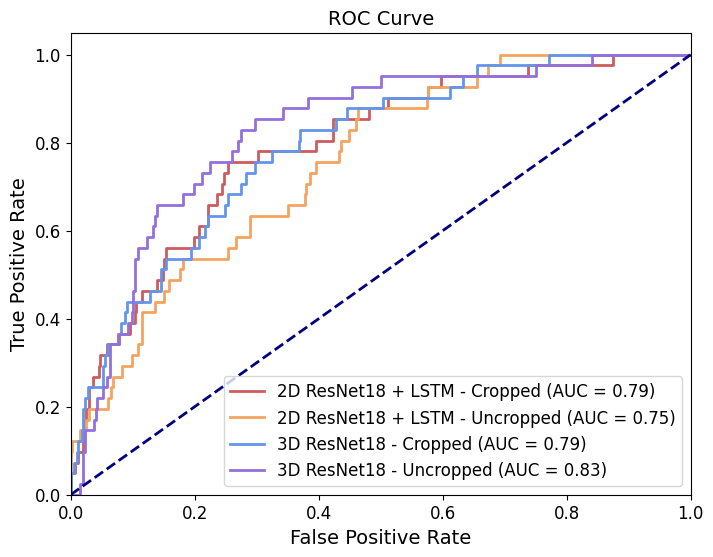

In [9]:
# ROC Curve
plt.figure(figsize=(8, 6))
for i, (model_name, label_df) in enumerate(label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = prob_dfs[model_name]
    pred_df = pred_dfs[model_name]

    # Calculate AUC score
    fprs, tprs, _ = roc_curve(label_df.values, prob_df.values)
    auc_score = auc(fprs, tprs)
    
    # Plot ROC curve
    plt.plot(fprs, tprs, color=colors[i], lw=2, label='{} (AUC = {:.2f})'.format(model_name, auc_score))

# Add labels and titles for ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

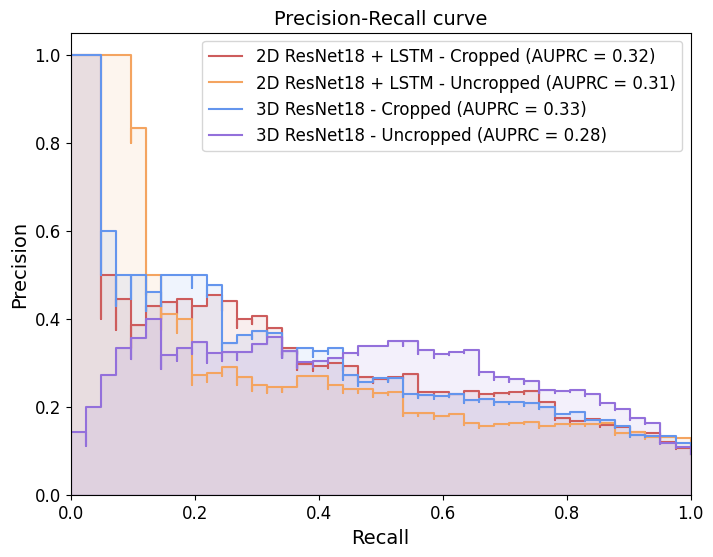

In [10]:
# AUPRC Curve
plt.figure(figsize=(8, 6))
for i, (model_name, label_df) in enumerate(label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = prob_dfs[model_name]
    pred_df = pred_dfs[model_name]

    # Calculate Precision and Recall
    precision, recall, _ = precision_recall_curve(label_df.values, prob_df.values)
    auprc_score = average_precision_score(label_df.values, prob_df.values)
    
    # Plot Precision-Recall curve
    plt.step(recall, precision, color=colors[i], where='post', label='{} (AUPRC = {:.2f})'.format(model_name, auprc_score))
    plt.fill_between(recall, precision, step='post', alpha=0.1, color=colors[i])

# Add labels and titles for Precision-Recall curve
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Precision-Recall curve', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()

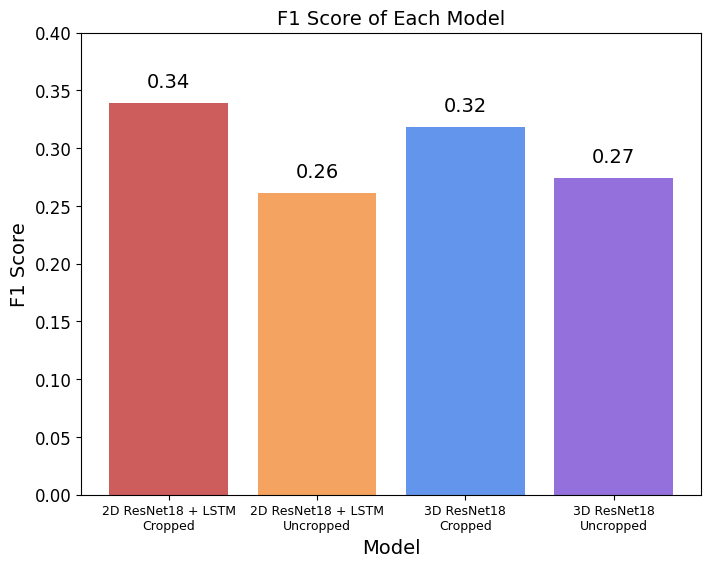

In [11]:
# F1 Score
f1_scores = []
model_names = []
new_model_names = ['2D ResNet18 + LSTM\nCropped', '2D ResNet18 + LSTM\nUncropped', '3D ResNet18\nCropped', '3D ResNet18\nUncropped']

# Iterate over model names and label dataframes
for model_name, label_df in label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = pred_dfs[model_name]
    
    # Calculate F1 score
    f1 = f1_score(label_df.values, pred_df.values, average='binary')
    
    # Append F1 score and model name to lists
    f1_scores.append(f1)
    model_names.append(model_name)

# Plot bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(new_model_names, f1_scores, color=colors)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.title('F1 Score of Each Model', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=9)
plt.ylim(0, 0.4)
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=14)
plt.show()




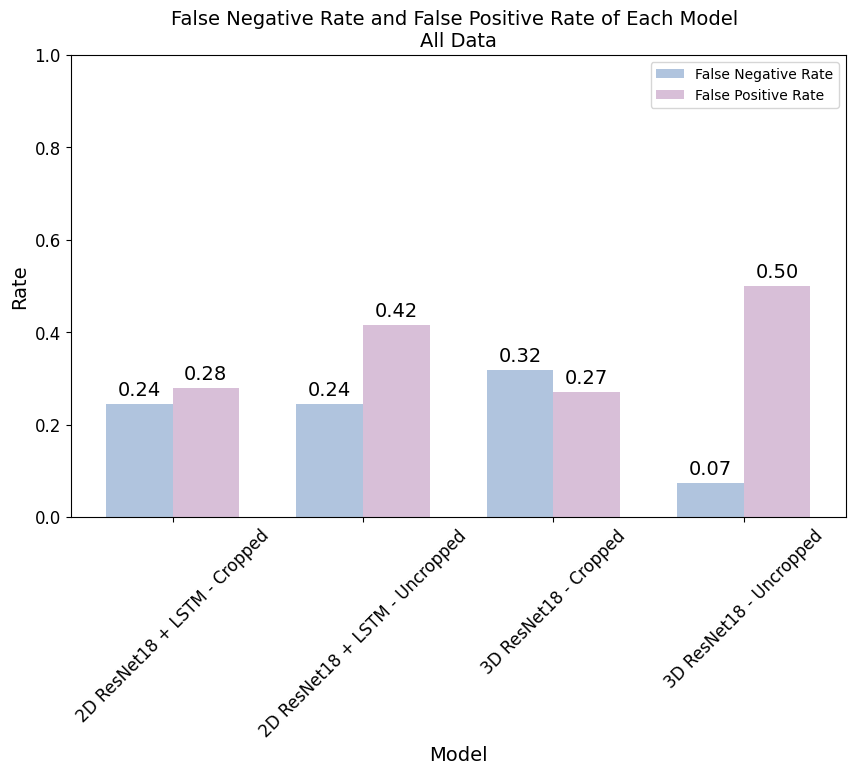

In [15]:
# FPR
fpr_scores = []
fnr_scores = []


# Calculate FPR for each model
for model_name, label_df in label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = pred_dfs[model_name]
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_df.values, pred_df.values).ravel()
    
    # Calculate FPR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # Append FPR to the list
    fpr_scores.append(fpr)
    fnr_scores.append(fnr)

# Set figure size and width of bars
plt.figure(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Set up x values for the bars
x = np.arange(len(model_names))

# Plot FNR bars
plt.bar(x - bar_width/2, fnr_scores, width=bar_width, color='lightsteelblue', label='False Negative Rate')

# Plot FPR bars
plt.bar(x + bar_width/2, fpr_scores, width=bar_width, color='thistle', label='False Positive Rate')

# Set labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Rate', fontsize=14)
plt.title('False Negative Rate and False Positive Rate of Each Model \nAll Data', fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.xticks(x, model_names, rotation=45, fontsize=12)
plt.legend()

# Add value labels to each bar
for i, score in enumerate(fnr_scores):
    plt.text(i - bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=14)

for i, score in enumerate(fpr_scores):
    plt.text(i + bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=14)

plt.show()


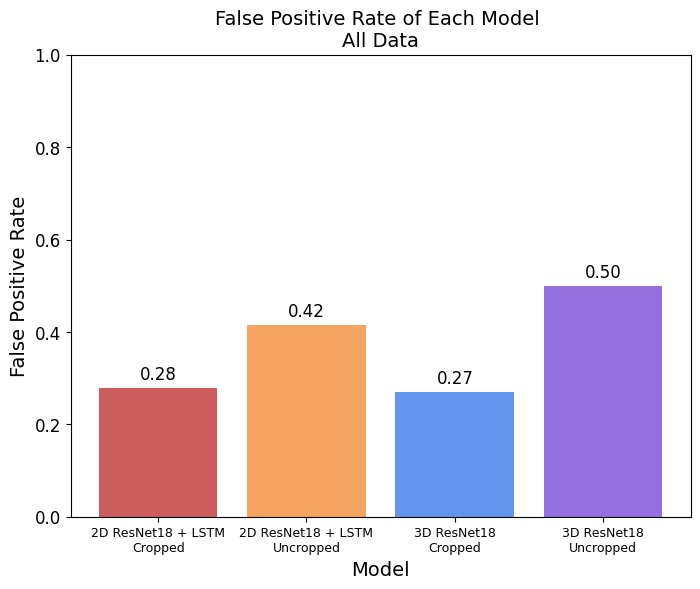

In [33]:
# FPR
fpr_scores = []

# Calculate FPR for each model
for model_name, label_df in label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = pred_dfs[model_name]
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_df.values, pred_df.values).ravel()
    
    # Calculate FPR
    fpr = fp / (fp + tn)
    
    # Append FPR to the list
    fpr_scores.append(fpr)

# Set figure size and width of bars
plt.figure(figsize=(8, 6))

# Plot FPR bars
plt.bar(new_model_names,  fpr_scores, color = colors)

# Set labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.title('False Positive Rate of Each Model \nAll Data', fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=9)

# Add value labels to each bar
for i, score in enumerate(fpr_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


## Explainability

In [16]:
class AbdominalDatasetInterpretability(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Select only the last 64 slices: 
        resized_image = resized_image[-64:, :, :]
            
        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

    
        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()
        series_id = torch.tensor(self.data_frame.loc[idx, 'series_id'])
        injury_situation = torch.tensor(self.data_frame.loc[idx, 'injury_situation'])

        sample = {'x': image, 'y': label, 'series_id': series_id, 'injury_situation': injury_situation}
        return sample



In [17]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

bs = 8

uncropped_interpretability_dataset = AbdominalDatasetInterpretability(os.path.join(data_directory, 'test_interpretability.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/')
cropped_interpretability_dataset = AbdominalDatasetInterpretability(os.path.join(data_directory, 'test_interpretability.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')

uncropped_interpretability_dataloader = DataLoader(uncropped_interpretability_dataset, batch_size=bs, shuffle=False)
cropped_interpretability_dataloader = DataLoader(cropped_interpretability_dataset, batch_size=bs, shuffle=False)

interpretability_dataloaders = [cropped_interpretability_dataloader, uncropped_interpretability_dataloader, cropped_interpretability_dataloader, uncropped_interpretability_dataloader, uncropped_interpretability_dataloader]

In [18]:
#Model Results:

# Initialize dictionaries to store dataframes for each model
interpretability_label_dfs = {}
interpretability_prob_dfs = {}
interpretability_pred_dfs = {}

# Iterate over models
for i, model in enumerate(classification_models):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([]) 
    all_preds = np.array([])
    all_series_ids = np.array([])
    all_injury_situations = np.array([])

    
    with torch.no_grad():
        dataloader = interpretability_dataloaders[i]
        print(i)
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            series_id = data['series_id'].to(device)
            injury_situation = data['injury_situation'].to(device)
            outputs = model(image)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs) 
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            all_series_ids = np.concatenate((all_series_ids, series_id.cpu().numpy()), axis=0)
            all_injury_situations = np.concatenate((all_injury_situations, injury_situation.cpu().numpy()), axis=0)

            total_samples += labels.size(0)
    
    # Create dataframes
    interpretability_label_df = pd.DataFrame({'Labels': all_labels, 'series_id': all_series_ids, 'injury_situation': all_injury_situations})
    interpretability_prob_df = pd.DataFrame({'Probabilities': all_probs, 'series_id': all_series_ids, 'injury_situation': all_injury_situations})
    interpretability_pred_df = pd.DataFrame({'Predictions': all_preds, 'series_id': all_series_ids, 'injury_situation': all_injury_situations})
    
    # Save dataframes in dictionaries
    interpretability_label_dfs[model_names[i]] = interpretability_label_df
    interpretability_prob_dfs[model_names[i]] = interpretability_prob_df
    interpretability_pred_dfs[model_names[i]] = interpretability_pred_df


0
1
2
3


In [19]:
with open('interpretability_label_dfs.pkl', 'wb') as f:
    pickle.dump(interpretability_label_dfs, f)

with open('interpretability_prob_dfs.pkl', 'wb') as f:
    pickle.dump(interpretability_prob_dfs, f)

with open('interpretability_pred_dfs.pkl', 'wb') as f:
    pickle.dump(interpretability_pred_dfs, f)

In [24]:
with open('interpretability_label_dfs.pkl', 'rb') as f:
    interpretability_label_dfs = pickle.load(f)

with open('interpretability_prob_dfs.pkl', 'rb') as f:
    interpretability_prob_dfs = pickle.load(f)

with open('interpretability_pred_dfs.pkl', 'rb') as f:
    interpretability_pred_dfs = pickle.load(f)

colors = ['indianred', 'sandybrown', 'cornflowerblue', 'mediumpurple', 'red']

### At least one other injury:

0: Everything healthy
1: Liver healthy, but at least one other not
2: Liver injured, and all others healthy
3: Liver injured, and at least one other injured

In [25]:
injury_situation_values = [1, 3]

organs_injured_label_dfs = {}
organs_injured_prob_dfs = {}
organs_injured_pred_dfs = {}

for model_name, label_df in interpretability_label_dfs.items():
    organs_injured_label_dfs[model_name] = label_df[label_df['injury_situation'].isin(injury_situation_values)]

for model_name, prob_df in interpretability_prob_dfs.items():
    organs_injured_prob_dfs[model_name] = prob_df[prob_df['injury_situation'].isin(injury_situation_values)]

for model_name, pred_df in interpretability_pred_dfs.items():
    organs_injured_pred_dfs[model_name] = pred_df[pred_df['injury_situation'].isin(injury_situation_values)]

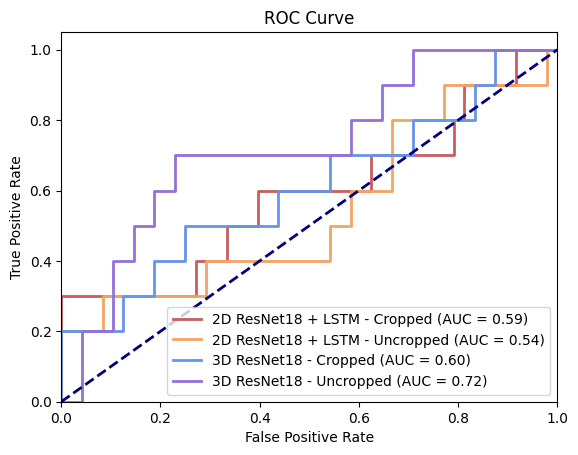

In [26]:

# ROC Curve
for i, (model_name, label_df) in enumerate(organs_injured_label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = organs_injured_prob_dfs[model_name]
    pred_df = organs_injured_pred_dfs[model_name]

    # Calculate AUC score
    fprs, tprs, _ = roc_curve(label_df['Labels'], prob_df['Probabilities'])
    auc_score = auc(fprs, tprs)
    
    # Plot ROC curve
    plt.plot(fprs, tprs, color=colors[i], lw=2, label='{} (AUC = {:.2f})'.format(model_name, auc_score))

# Add labels and titles for ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

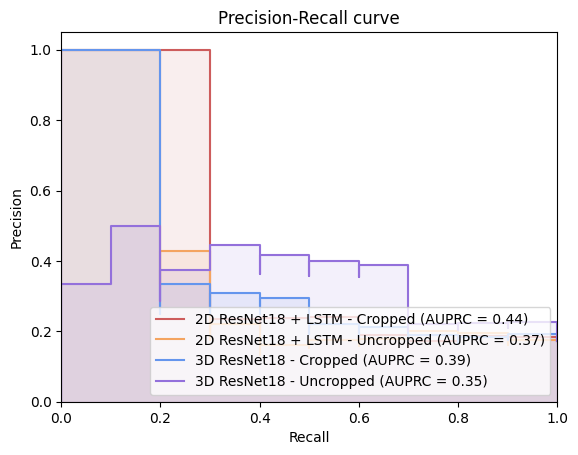

In [27]:
# AUPRC Curve
for i, (model_name, label_df) in enumerate(organs_injured_label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = organs_injured_prob_dfs[model_name]
    pred_df = organs_injured_pred_dfs[model_name]

    # Calculate Precision and Recall
    precision, recall, _ = precision_recall_curve(label_df['Labels'], prob_df['Probabilities'])
    auprc_score = average_precision_score(label_df['Labels'], prob_df['Probabilities'])
    
    # Plot Precision-Recall curve
    plt.step(recall, precision, color=colors[i], where='post', label='{} (AUPRC = {:.2f})'.format(model_name, auprc_score))
    plt.fill_between(recall, precision, step='post', alpha=0.1, color=colors[i])

# Add labels and titles for Precision-Recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower right')
plt.show()

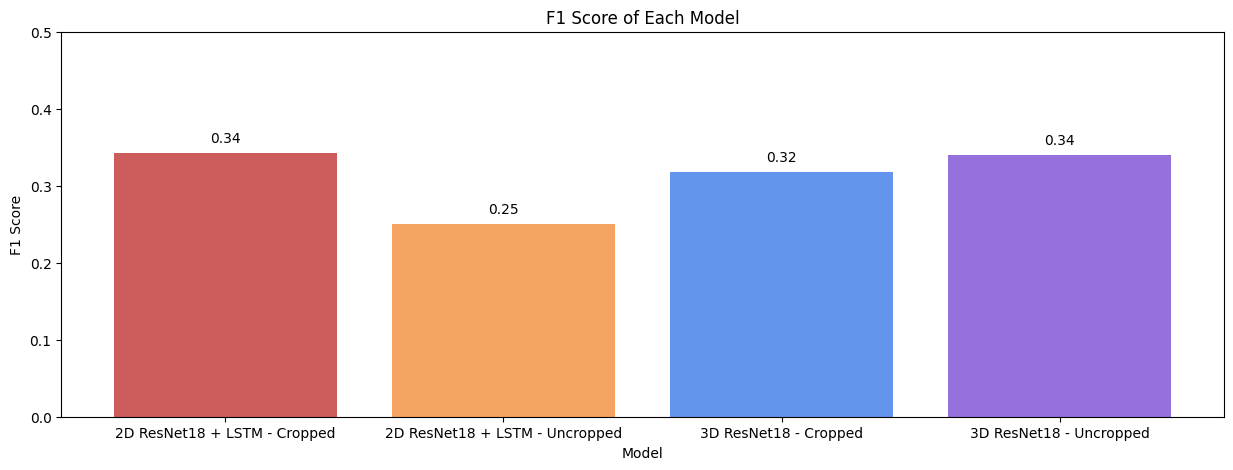

In [28]:
# F1 Score
f1_scores = []
model_names = []

# Iterate over model names and label dataframes
for model_name, label_df in organs_injured_label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = organs_injured_pred_dfs[model_name]
    
    # Calculate F1 score
    f1 = f1_score(label_df['Labels'], pred_df['Predictions'], average='binary')
    
    # Append F1 score and model name to lists
    f1_scores.append(f1)
    model_names.append(model_name)

# Plot bar plot
plt.figure(figsize=(15, 5))
bars = plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score of Each Model')
plt.ylim(0, 0.5)
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')
plt.show()




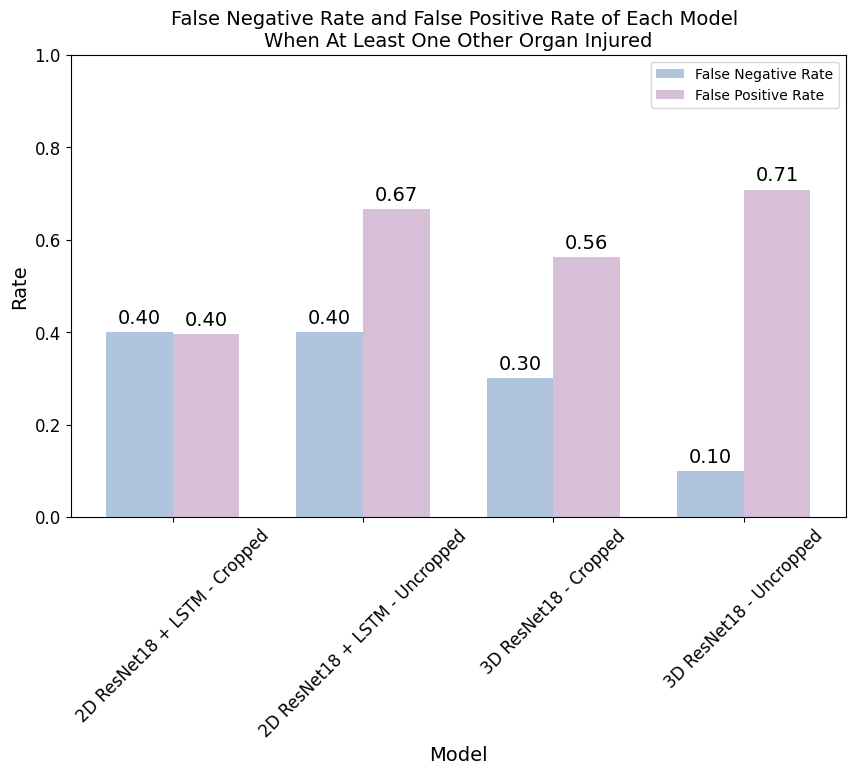

In [29]:
fpr_scores = []
fnr_scores = []


# Calculate FPR for each model
for model_name, label_df in organs_injured_label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = organs_injured_pred_dfs[model_name]
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_df['Labels'], pred_df['Predictions']).ravel()
    
    # Calculate FPR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # Append FPR to the list
    fpr_scores.append(fpr)
    fnr_scores.append(fnr)

# Set figure size and width of bars
plt.figure(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Set up x values for the bars
x = np.arange(len(model_names))

# Plot FNR bars
plt.bar(x - bar_width/2, fnr_scores, width=bar_width, color='lightsteelblue', label='False Negative Rate')

# Plot FPR bars
plt.bar(x + bar_width/2, fpr_scores, width=bar_width, color='thistle', label='False Positive Rate')

# Set labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Rate', fontsize=14)
plt.title('False Negative Rate and False Positive Rate of Each Model \nWhen At Least One Other Organ Injured', fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.xticks(x, model_names, rotation=45, fontsize=12)
plt.legend()

# Add value labels to each bar
for i, score in enumerate(fnr_scores):
    plt.text(i - bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=14)

for i, score in enumerate(fpr_scores):
    plt.text(i + bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=14)

plt.show()


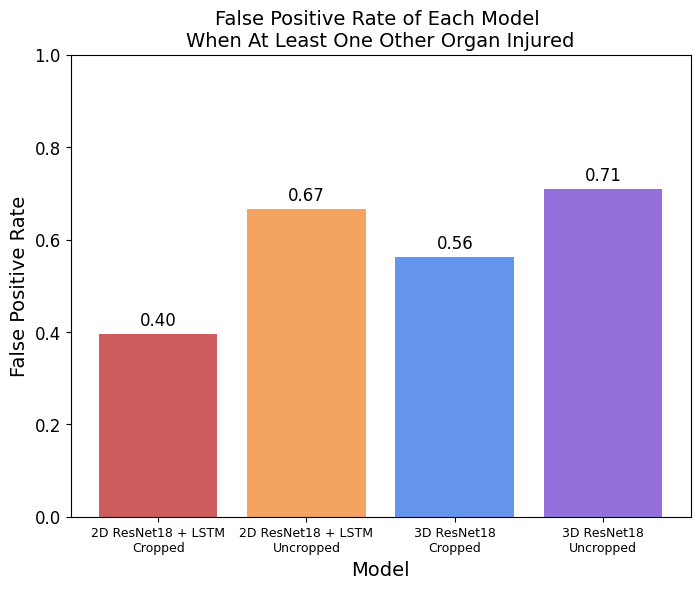

In [32]:
fpr_scores = []

# Calculate FPR for each model
for model_name, label_df in organs_injured_label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = organs_injured_pred_dfs[model_name]
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_df['Labels'], pred_df['Predictions']).ravel()
    
    # Calculate FPR
    fpr = fp / (fp + tn)
    
    # Append FPR to the list
    fpr_scores.append(fpr)

# Set figure size and width of bars
plt.figure(figsize=(8, 6))

# Plot FPR bars
plt.bar(new_model_names, fpr_scores, color=colors)

# Set labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.title('False Positive Rate of Each Model \nWhen At Least One Other Organ Injured', fontsize=14)
plt.ylim(0, 1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=9)

# Add value labels to each bar
for i, score in enumerate(fpr_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


### No other injury:

In [26]:
# Filter dataframes for injury_situation = 0 or 2 (other organs healthy)
injury_situation_values = [0, 2]

organs_healthy_label_dfs = {}
organs_healthy_prob_dfs = {}
organs_healthy_pred_dfs = {}

for model_name, label_df in interpretability_label_dfs.items():
    organs_healthy_label_dfs[model_name] = label_df[label_df['injury_situation'].isin(injury_situation_values)]

for model_name, prob_df in interpretability_prob_dfs.items():
    organs_healthy_prob_dfs[model_name] = prob_df[prob_df['injury_situation'].isin(injury_situation_values)]

for model_name, pred_df in interpretability_pred_dfs.items():
    organs_healthy_pred_dfs[model_name] = pred_df[pred_df['injury_situation'].isin(injury_situation_values)]

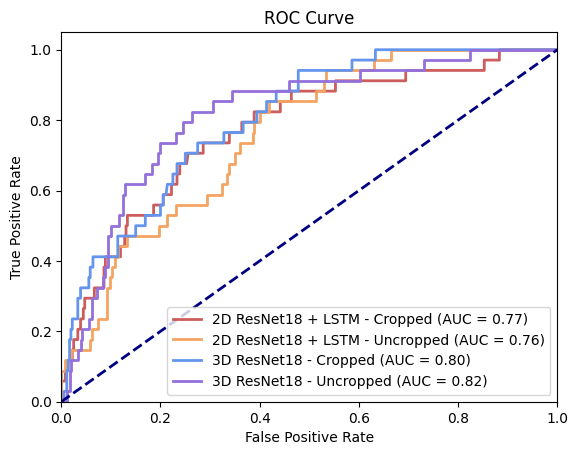

In [27]:
# ROC Curve
for i, (model_name, label_df) in enumerate(organs_healthy_label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = organs_healthy_prob_dfs[model_name]
    pred_df = organs_healthy_pred_dfs[model_name]

    # Calculate AUC score
    fprs, tprs, _ = roc_curve(label_df['Labels'], prob_df['Probabilities'])
    auc_score = auc(fprs, tprs)
    
    # Plot ROC curve
    plt.plot(fprs, tprs, color=colors[i], lw=2, label='{} (AUC = {:.2f})'.format(model_name, auc_score))

# Add labels and titles for ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

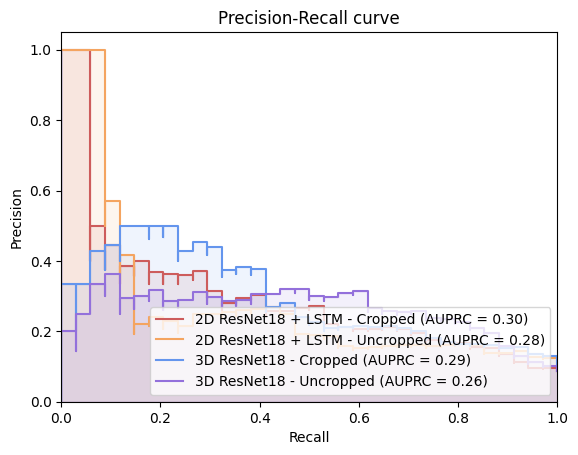

In [28]:
# AUPRC Curve
for i, (model_name, label_df) in enumerate(organs_healthy_label_dfs.items()):
    total_samples = len(label_df)
    
    # Retrieve probability and prediction dataframes based on model name
    prob_df = organs_healthy_prob_dfs[model_name]
    pred_df = organs_healthy_pred_dfs[model_name]

    # Calculate Precision and Recall
    precision, recall, _ = precision_recall_curve(label_df['Labels'], prob_df['Probabilities'])
    auprc_score = average_precision_score(label_df['Labels'], prob_df['Probabilities'])
    
    # Plot Precision-Recall curve
    plt.step(recall, precision, color=colors[i], where='post', label='{} (AUPRC = {:.2f})'.format(model_name, auprc_score))
    plt.fill_between(recall, precision, step='post', alpha=0.1, color=colors[i])

# Add labels and titles for Precision-Recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower right')
plt.show()

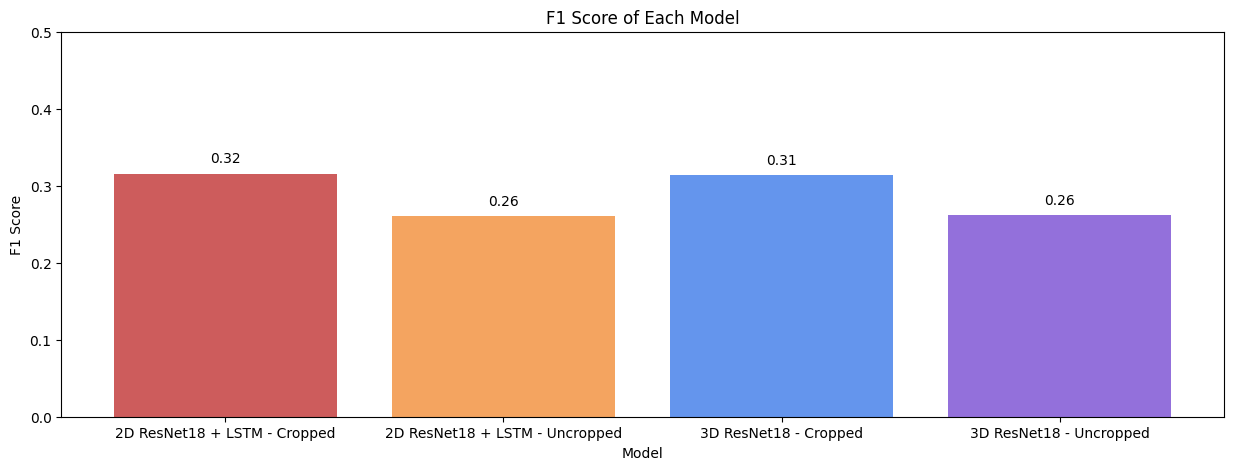

In [29]:
# F1 Score
f1_scores = []
model_names = []

# Iterate over model names and label dataframes
for model_name, label_df in organs_healthy_label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = organs_healthy_pred_dfs[model_name]
    
    # Calculate F1 score
    f1 = f1_score(label_df['Labels'], pred_df['Predictions'], average='binary')
    
    # Append F1 score and model name to lists
    f1_scores.append(f1)
    model_names.append(model_name)

# Plot bar plot
plt.figure(figsize=(15, 5))
bars = plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score of Each Model')
plt.ylim(0, 0.5)
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')
plt.show()




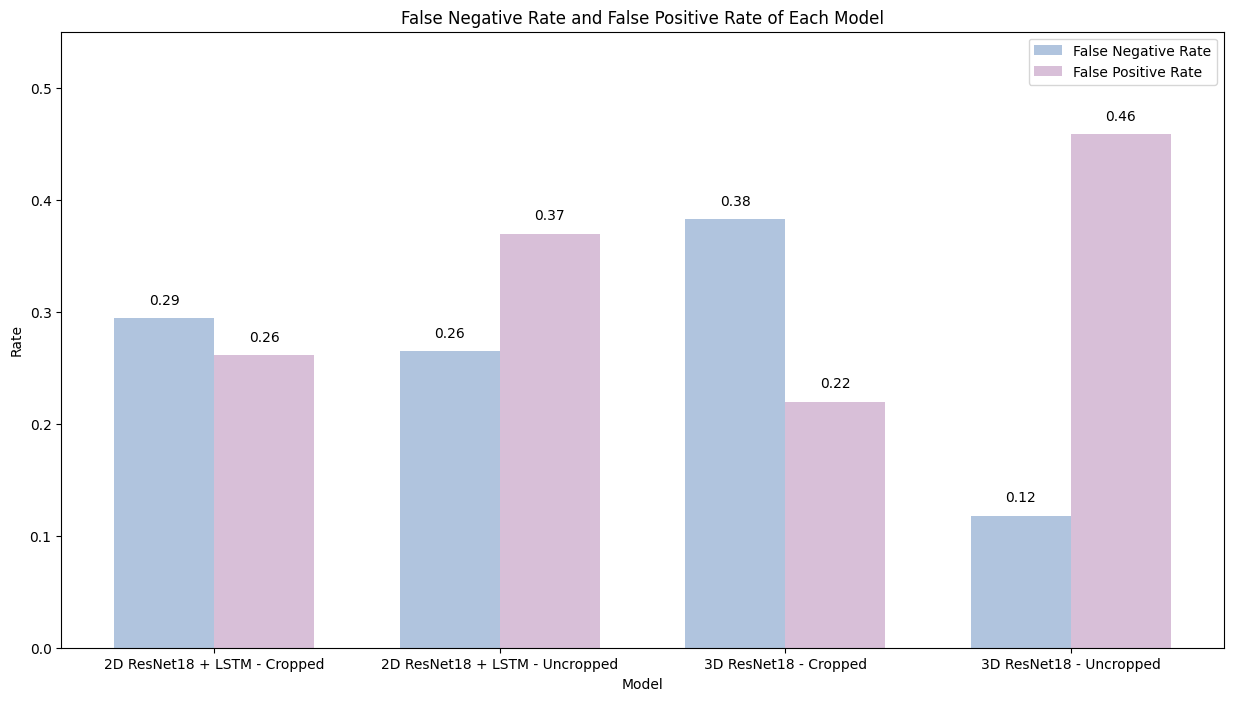

In [30]:
# FPR
fpr_scores = []
fnr_scores = []


# Calculate FPR for each model
for model_name, label_df in organs_healthy_label_dfs.items():
    # Retrieve probability and prediction dataframes based on model name
    pred_df = organs_healthy_pred_dfs[model_name]
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_df['Labels'], pred_df['Predictions']).ravel()
    
    # Calculate FPR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # Append FPR to the list
    fpr_scores.append(fpr)
    fnr_scores.append(fnr)

# Set figure size and width of bars
plt.figure(figsize=(15, 8))

# Define bar width
bar_width = 0.35

# Set up x values for the bars
x = np.arange(len(model_names))

# Plot FNR bars
plt.bar(x - bar_width/2, fnr_scores, width=bar_width, color='lightsteelblue', label='False Negative Rate')

# Plot FPR bars
plt.bar(x + bar_width/2, fpr_scores, width=bar_width, color='thistle', label='False Positive Rate')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('Rate')
plt.title('False Negative Rate and False Positive Rate of Each Model')
plt.ylim(0,0.55)
plt.xticks(x, model_names)
plt.legend()

# Add value labels to each bar
for i, score in enumerate(fnr_scores):
    plt.text(i - bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

for i, score in enumerate(fpr_scores):
    plt.text(i + bar_width/2, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

plt.show()
